checking info from dataset Handling null values and duplicate values

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # Import PCA
from google.colab import files

# Upload the dataset
uploaded = files.upload()

# Load your dataset (replace 'data.csv' with the actual filename)
file_name = 'data.csv'  # Adjust this if your file has a different name
df = pd.read_csv(file_name)

# Display the first few rows and information about the dataset
print("Head of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()

# Display summary statistics to understand the data distribution
print("\nSummary Statistics:")
print(df.describe())

# Automatically identify numerical columns for scaling
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
print("\nNumerical features selected for scaling:", numerical_features)

# Initialize and apply StandardScaler to the selected numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numerical_features])

# Convert scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features)

# Display the head of the scaled features to confirm scaling
print("\nHead of scaled features:")
print(scaled_df.head())


Saving data.csv to data.csv
Head of the dataset:
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800    

StandardScaler: Each feature will have a mean of 0 and a standard deviation of 1, making all features comparable.
Why Scale?: Without scaling, features with larger values (like TotalSpend) could dominate smaller ones (like Quantity), which would skew clustering results.

In [ ]:
# Experiment with different numbers of principal components to capture more variance
pca = PCA(n_components=10)  # You can increase this number to capture more variance
pca_features = pca.fit_transform(scaled_df)

# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Display the cumulative variance for each number of components
for i, cumulative in enumerate(cumulative_variance):
    print(f"Cumulative variance with {i + 1} components: {cumulative}")

# Choose an appropriate number of components based on your desired variance (e.g., ~0.8 or ~0.9)


Cumulative variance with 1 components: 0.3026607774628878
Cumulative variance with 2 components: 0.46155627718646786
Cumulative variance with 3 components: 0.5574925166914402
Cumulative variance with 4 components: 0.6449749930362092
Cumulative variance with 5 components: 0.7220864518899236
Cumulative variance with 6 components: 0.7880290774949668
Cumulative variance with 7 components: 0.8414372749965324
Cumulative variance with 8 components: 0.8883132590662443
Cumulative variance with 9 components: 0.9220782459860007
Cumulative variance with 10 components: 0.9538692657486822


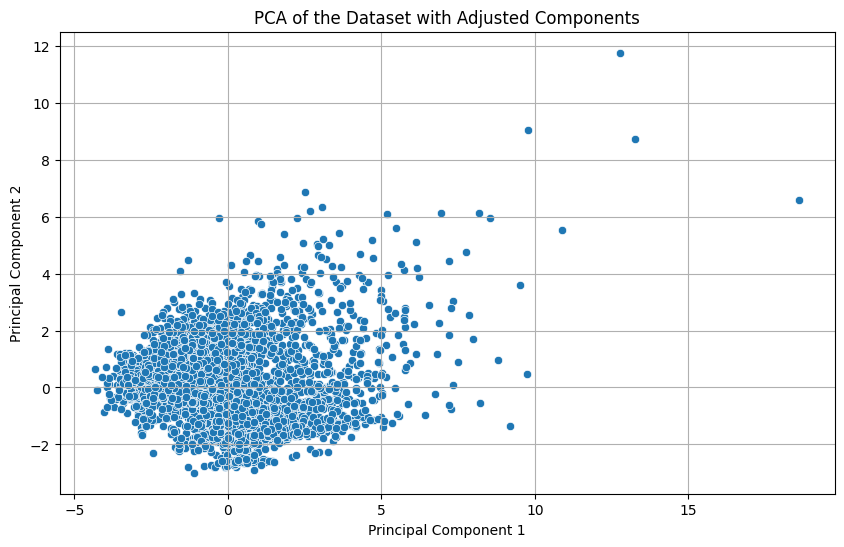

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming PCA has already been applied and results stored in `pca_features` with updated components
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])

# Plot the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('PCA of the Dataset with Adjusted Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


Each point in the plot represents a transaction in the dataset, positioned according to the values of its first and second principal components (PC1 and PC2).
PC1 and PC2 are new dimensions that capture the most significant variations in the data. PC1 captures the most variation, while PC2 captures the second most.
Data Points:

Points close together indicate transactions that are more similar in terms of their quantities, unit prices, and total spend.
Points farther apart are less similar, showing differences in spending patterns.

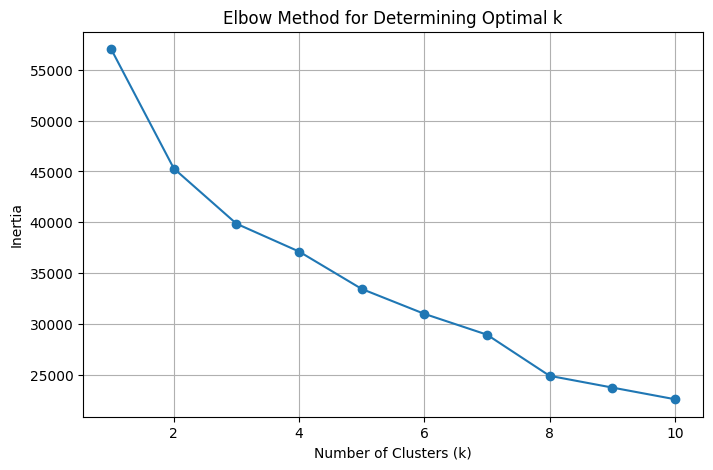

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range for potential cluster numbers (k values)
k_values = range(1, 11)
inertia = []

# Calculate inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Plot the inertia values to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal k')
plt.grid()
plt.show()


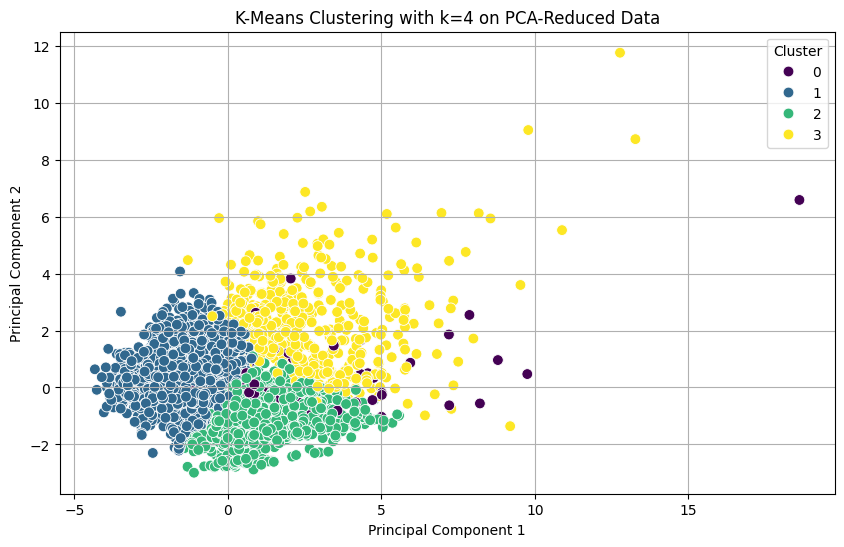

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Apply K-Means with the optimal k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_df)  # Assuming you’re working with the PCA-reduced data

# Add the cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_labels

# Visualize the clusters in the 2D PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=60)
plt.title('K-Means Clustering with k=4 on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


Fit K-Means with
𝑘
=
4
k=4: Apply K-Means clustering to your dataset using this value of
𝑘
k.
Assign Cluster Labels: Add the cluster labels to your DataFrame to understand which points belong to each cluster.
Visualize the Clusters: Plot the clusters to observe how the data is grouped.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset (for local execution)
# Uncomment the line below and specify the correct path if running locally
# file_path = r"C:\Users\sathv\Downloads\data.csv"

# For Google Colab: Upload the CSV file
from google.colab import files
uploaded = files.upload()

# After uploading, get the filename
file_path = next(iter(uploaded))  # This gets the name of the uploaded file

# Load the dataset
data = pd.read_csv(file_path)

# Define the features for clustering
features = data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition',
                 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Add DBSCAN cluster labels to your data
data['dbscan_cluster'] = dbscan_labels

# Use PCA to reduce dimensions for 2D visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot the DBSCAN clusters
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in range(len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise points
        col = [0, 0, 0, 1]
    class_member_mask = (dbscan_labels == k)
    xy = features_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title("DBSCAN Clustering Visualization with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from google.colab import files
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Upload and load dataset
uploaded = files.upload()
file_name = next(iter(uploaded))  # Automatically gets the uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
unique_city

# Step 2: Data transformation
# Binning 'price' and 'sqft_living' into categories
df['price_cat'] = pd.qcut(df['price'], 3, labels=['Low', 'Medium', 'High'])
df['sqft_cat'] = pd.qcut(df['sqft_living'], 3, labels=['Small', 'Medium', 'Large'])

# Using 'bedrooms' and 'bathrooms' directly after converting to string with labels
df['bedrooms'] = df['bedrooms'].astype(str) + ' bedrooms'
df['bathrooms'] = df['bathrooms'].astype(str) + ' bathrooms'

# Creating a list of items per transaction (row)
df['items'] = df[['price_cat', 'sqft_cat', 'bedrooms', 'bathrooms']].apply(lambda x: x.tolist(), axis=1)

# Step 3: Encode the data for the Apriori Algorithm
encoder = TransactionEncoder()
transaction_encoded = encoder.fit_transform(df['items'].tolist())
df_encoded = pd.DataFrame(transaction_encoded, columns=encoder.columns_)

# Step 4: Find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)

# Step 5: Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Step 6: Display the rules with support, confidence, and lift
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving data.csv to data (5).csv
                             antecedents      consequents   support  \
0                        (1.0 bathrooms)            (Low)  0.105652   
1                        (1.0 bathrooms)          (Small)  0.143696   
2                       (1.75 bathrooms)   (3.0 bedrooms)  0.085217   
3                       (1.75 bathrooms)         (Medium)  0.097391   
4                        (2.0 bathrooms)         (Medium)  0.061522   
5                         (2.0 bedrooms)          (Small)  0.103478   
6                       (2.25 bathrooms)         (Medium)  0.064783   
7                         (5.0 bedrooms)          (Large)  0.056522   
8                                 (High)          (Large)  0.227174   
9                                (Large)           (High)  0.227174   
10                 (Small, 2.0 bedrooms)  (1.0 bathrooms)  0.065217   
11         (1.0 bathrooms, 2.0 bedrooms)          (Small)  0.065217   
12         (1.0 bathrooms, 3.0 bedrooms)     

Overview
This script is designed to perform association rule mining on a real estate dataset. The goal is to uncover interesting relationships between different attributes of properties (like price, square footage, number of bedrooms, and bathrooms) that appear frequently together and meet certain confidence and support thresholds.

Price and Square Footage: These numerical attributes are categorized into 'Low', 'Medium', and 'High' for prices, and 'Small', 'Medium', and 'Large' for living areas, using quantiles. This step helps in grouping the properties into comparable segments.
Bedrooms and Bathrooms: These are converted to string labels (e.g., '3 bedrooms') to treat them as categorical items suitable for rule mining.
A new column 'items' is created for each property listing, combining these attributes into a list, representing a transaction in market-basket analysis terms.
Data Encoding:

The transaction lists are encoded into a format suitable for mining. This involves creating a matrix where each row represents a listing and each column represents a possible attribute. Each cell in the matrix is True if the attribute is present in the listing, otherwise False.
Mining Frequent Itemsets:

The script uses the Apriori algorithm to find frequent itemsets among the listings. An itemset is considered frequent if it appears in at least 5% of the transactions (this threshold can be adjusted as needed).
Generating Association Rules:

From the frequent itemsets, the script generates association rules that have a confidence of at least 60%. Confidence measures the reliability of the rule.
Results Display:

The script displays the rules along with their support, confidence, and lift metrics:
Support: The proportion of transactions that include both the antecedent and the consequent of the rule.
Confidence: The probability that a transaction with the antecedent will also have the consequent.
Lift: The ratio of the observed support to that expected if the antecedent and consequent were independent.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df is already loaded with your data
# Example filter: Focus on properties in a specific city, e.g., 'Seattle'
target_city = 'Seattle'
df_city = df[df['city'] == target_city]

# Select and preprocess features
features = ['price', 'sqft_living', 'bedrooms', 'bathrooms']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ])

# Fit and transform the data
X_city = preprocessor.fit_transform(df_city[features])

# Compute cosine similarity matrix for the filtered city data
similarity_matrix = cosine_similarity(X_city)

# Convert the similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix, index=df_city.index, columns=df_city.index)

# Function to recommend properties within the same city
def recommend_properties_city(index, num_recommendations=5):
    if index in similarity_df.index:
        sim_scores = similarity_df.loc[index]
        most_similar = sim_scores.sort_values(ascending=False)
        recommended_indices = most_similar.iloc[1:num_recommendations + 1].index
        recommended_properties = df_city.loc[recommended_indices]
        return recommended_properties
    else:
        return "Index not found in the current city filter."

# Example usage
property_index = df_city.index[0]  # Using the first index from the city-filtered DataFrame
recommendations = recommend_properties_city(property_index, 5)
print(recommendations)


                     date      price  bedrooms  bathrooms  sqft_living  \
3964  2014-07-05 00:00:00  1738000.0       4.0       2.25         2920   
2533  2014-06-16 00:00:00  1735000.0       4.0       2.25         3040   
2412  2014-06-12 00:00:00  1688000.0       4.0       2.50         3000   
4042  2014-07-07 00:00:00  1300000.0       4.0       2.25         2360   
11    2014-05-02 00:00:00  1400000.0       4.0       2.50         2920   

      sqft_lot  floors  waterfront  view  condition  sqft_above  \
3964      6513     2.0           0     0          4        2260   
2533      5000     2.0           0     3          4        2080   
2412      7500     2.0           0     0          3        3000   
4042      4000     2.0           0     0          3        2360   
11        4000     1.5           0     0          5        1910   

      sqft_basement  yr_built  yr_renovated                 street     city  \
3964            660      1937             0   1987 Shenandoah Dr E  Seatt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


content based recomendation based on citys using data.csv, dataset  Content-based recommendation is a type of recommendation system that suggests items similar to those a user has liked or interacted with in the past, based on the content of the items themselves. This system uses features of the items to determine their similarity and make recommendations

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df_city is already loaded with your Seattle data

# Simulate a user-item rating matrix (let's assume we have 100 users)
np.random.seed(42)  # for reproducibility
num_users = 100
user_item_matrix = pd.DataFrame(
    np.random.randint(0, 5, size=(num_users, len(df_city))),  # ratings between 0 and 4
    columns=df_city.index
)

# Compute cosine similarity matrix among users
user_similarity_matrix = cosine_similarity(user_item_matrix.values)

# Convert the similarity matrix to a DataFrame for easier handling
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=range(num_users), columns=range(num_users))

# Function to recommend properties based on user similarity
def recommend_properties_user_based(user_id, num_recommendations=5):
    # Get similarity scores for the given user with all other users
    sim_scores = user_similarity_df.loc[user_id]

    # Sort the users based on similarity scores, excluding the user itself
    most_similar_users = sim_scores.sort_values(ascending=False).iloc[1:]

    # Get the top N similar users
    top_users = most_similar_users.head(num_recommendations).index

    # Aggregate their top-rated properties
    recommended_indices = user_item_matrix.loc[top_users].mean().sort_values(ascending=False).head(num_recommendations).index

    # Return the recommended properties
    return df_city.loc[recommended_indices]

# Example usage
user_id = 1  # Example user ID
recommended_properties = recommend_properties_user_based(user_id, 5)
print(recommended_properties)


                     date      price  bedrooms  bathrooms  sqft_living  \
44    2014-05-02 00:00:00   235000.0       2.0       1.00         1210   
1226  2014-05-23 00:00:00   662990.0       3.0       1.75         1240   
2909  2014-06-19 00:00:00   607500.0       3.0       3.25         1530   
1617  2014-05-30 00:00:00  1365000.0       3.0       2.50         2090   
2149  2014-06-09 00:00:00   352750.0       2.0       1.75         1060   

      sqft_lot  floors  waterfront  view  condition  sqft_above  \
44        9400     1.0           0     0          2        1210   
1226      3600     1.5           0     0          5        1240   
2909      1612     3.0           0     0          3        1530   
1617      6000     1.5           0     0          4        2090   
2149      1241     2.0           0     0          3         960   

      sqft_basement  yr_built  yr_renovated            street     city  \
44                0      1949             0  7542 21st Ave SW  Seattle   
1226

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


user based recomendation